[TR]
# **BTK - Huawei Kodlama Maratonu (2022 - AI)** 
## **Yapay zeka kullanarak uydu görüntüsünü segmentlere ayırma projesi**

### **Özet**

Bu proje Ömer SAVAŞ tarafından geliştirilmiştir. Genel olarak Donanım/Zaman kısıtı dolayısı ile bilinçli olarak optimum derinlikte bir ağ oluşturulup kısıtlı bir eğitim gerçekleştirilmiştir. Daha derin bir ağ ile daha uzun süre eğitim gerçekleştirilir ise doğruluk daha da artacaktır. 

Bunun yanında disk kısıtı nedeni ile model eğitilirken callback mekanizması ile eğitim ağırlıkları peryodik olarak kaydedilememiş, bunun yerine manuel bir kayıt mekanizması kurularak hep aynı dosya üzerine ağırlıklar güncellenmiştir.

"train.ipbynb" eğitim işlemlerini gerçekleştirmek için gerekli olan dosyadır. Akış içerisindeki adımları gerçekleştirerek eğitimi tamamlar. Eğitim sonucunda elde edilen ağırlıkları kullanarak istenilen "output.csv" ve "scores.txt" dosyalarını export etmek için "predict.ipynb" dosyası kullanılmalıdır.

Ayrıca tarafınızdan gönderilen dokümanlarda geçen sorular ve aşamalar bu belge içerisinde başlık başlık açıklanmıştır. Tarafınızdan istenilen içerik başlıkları ve sorular kalın olarak vurgulanmıştır.

### **Akış**

1.   Kütüphanelerin yüklenmesi ve içeri aktarılması
2.   Yardımcı fonksiyonların ve değişkenlerin tanımlanması
3.   Veri setinin okunması ve sonrası için cache yapılması
4.   Veri setinin normalizasyonu ve uygun formatlara getirilmesi
5.   Modelin tasarlanması
6.   Eğitimin gerçekleştirilmesi ve ağırlıkların kaydedilmesi
7.   Kayıp ve doğruluk verilerinin değerlendirilmesi
8.   Test setinin tahmin işlemi ve önizlenmesi

### **Proje Açıklaması**

#### **Genel**

Bu projede kullanmak için derin öğrenme modellerinden autoencode ve mask rcnn modelleri arasında kalınmış ve autoencoder seçilmiştir. Seçilme kriterleri "Hangi makine öğrenmesi modelini seçtiniz?" başlığı altında anlatılmıştır.

İlk olarak çok küçük bir model ile bir kaç epoch eğitim gerçekleştirilerek aşağıdaki resimlere ulaşılmış ve autoencoder modelinin bu sorunu çözme konuşunda başarılı olabileceği görülmüştür. Model kaynak kodu ve ilk tahmin resimleri aşağıdadır

```python
input_img = Input(shape = (size, size, 3))
x = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

x = Conv2D(16, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
```

![autoencoderminimodelpredict.jpg](https://omersavas.com/dosya/huawei/autoencoderminimodelpredict.jpg)

Ardından kaynak 2 de belirtilen model incelenmiş ve bizim mini autoencoderimiz ve kaynaktaki modelin arasında bir derinlik seçilmiştir. Bazı katmanlar sadeleştirilerek aşağıda özeti ve diagram resmi çizilmiş olan modelde karar kılınmıştır. Bu model yine bir kaç epoch eğitimden geçirildikten sorna önceki modelden çok daha başarılı olacağı aşağıdaki resimden de anlaşılmaktadır.

![model](https://omersavas.com/dosya/huawei/model.png)

Sonuç olarak eğitim gerçekleştirilmiş ve grafikler aşağıdadır. Donanım kaynağının yetersizliği sebebiyle eğitim küçük bir veri seti ile gerçekleştirilmiştir. Bu da ilerleyen iterasyonlarda bir miktar aşırı öğrenme yaptır. Eğer daha büyük veri seti ve daha derin ağ ile eğitim gerçekleştirilir ise doğruluk performansının artacağı düşünülmektedir.

![acc](https://omersavas.com/dosya/acc.png)

#### **Veri kümesinde hangi veri ön işleme adımlarını uyguladınız? **
Veri okuma, formatlama, normalize etme gibi işlemler read_images() fonksiyonu içerisinde gerçekleştirildi. Önce jp2 uzantılı uydu görüntüleri RGB ye çevirildi. Ardından numpy dizisine dönüştürülüp /255 e bölündü. .tif uzantılı segment dosyaları da tek kanal olarak okunduktan sonra one hot vektörlere dönüştürüldü.

#### **Öznitelikleri nasıl belirlediniz?**
Autoencoder (derin öğrenme) modeli ile eğitim gerçekleştirildiği için ekstra bir öznitelik çıkarımı yapılmadı. Yalnızca .tif uzantılı dosyaların içindeki "0" yani tanımsız dataları için sınıf listesinin ilk elemanı olarak "undefined" eklendi. Eğitim gerçekleştirkten sonra output.csv ve socres.txt dosyaları export edilirken de undefined sınıfı görmezden gelindi.

#### **Veri kümesini modeli hazırlamak için nasıl kullandınız?**
Veri kümesi incelendiğinde Mask RCNN modeli için .tif dosyalarından, sınıfların alanlarını poligonlar olarak eğitim öncesinde hazırlanması gerektiği görüldü. Bu sebeple o modelden vazgeçilerek elimizdeki veri setine ve probleme daha uygun olacağı düşünülen autoencoder modeli kullanılmaya karar verildi.

#### **Hangi makine öğrenmesi modelini seçtiniz?**
Model olarak, görüntü işleme konusunda kendisini kanıtlamış olan derin öğrenme seçildi. Derin öğrenme yaklaşımları içerisinde de Mask RCNN ve Autoencoder üzerinde duruldu. Aslında ilk bakışta mask RCNN modelinin daha yüksek doğruluk vereceği düşünülmüş olsa da .tif uzantılı segment verisinden poligonlar halinde öznitelik konumları ayrı bir dosya olarak oluşturulması gerektiğinden[1] autoencoder yaklaşımı tercih edildi. Autoencoder modeller yapısı gereği ekstra bir öznitelik datasına ihtiyaç duymadan bilgisayarlı görü alanında kaynak bir resme bakarak istenilen resimleri üretmede gayet başarılıdır.

#### **Seçtiğiniz modelin parametrelerini nasıl belirlediniz**
Daha önce gürültü temizleme gibi çeşitli işler için autoencoder modelini kullanmıştım. Temel olarak mini bir auto encoder model ile bir kaç epoch test gerçekleştirildi ve modelin sorunun çözümüne uygun olduğuna karar verildi. 
Ardından kaynak 2 'deki model sadeleştirilerek daha performanslı çalışacak halini kullanmaya karar verildi. Sonrasında küçük bir veri seti ile bu soruna özel testler yaparak öğrenme oranı, optimizasyon algoritması gibi hiperparametreler değiştirerek daha iyi sonuçlar elde etmeye çalışıldı.

#### **Gönderilen dokümanda istenilen proje adımları hakkında açıklamalar** 
##### **1- Veri Ön-işleme**
"**Yardımcı fonksiyonların ve değişkenlerin tanımlanması**" başlığı altında "**read_images**" fonksiyonu bu işlemi gerçekleştirmektedir. Daha detaylı açıklama yine bu dokümanın "**Veri kümesinde hangi veri ön işleme adımlarını uyguladınız? **" üst başlığında bulunmaktadır.

##### **2- Makine Öğrenmesi modelinin seçimi**
Bu dokümanın "**Hangi makine öğrenmesi modelini seçtiniz?**" üst başlığında model seçimi hakkında teorik bilgi ve kıyaslamalar bulunmaktadır. Ayrıca
"**Modelin tasarlanması**" bölümünde model ve katmanları detaylı olarak kodlanmıştır. Devam eden bloklarda da modelin özeti ve diagram çizimleri vardır.

##### **3- Modelin eğitilmesi**
"**Eğitimin gerçekleştirilmesi ve ağırlıkların kaydedilmesi**" bölümünde tasarlanmış olan model eğitimi gerçekleştirilmiştir. Yukarıda da belirtildiği üzere disk kısıtı problemi sebebiyle manuel bir ağırlık ve öğrenim bilgisi kaydetme mekanizması yine aynı bölümde kodlanmıştır.

##### **4- Model performansının ölçülmesi**
Doğrulama seti ile eğitim esnasında doğruluk performansı adım adım ölçülmektedir. Ayrıca öğrenim bilgisi her adım için kaydedilmesinden dolayı kayıp ve doğruluk bilgileri eğitim kısmından sonra grafik olarak izlenmiştir. Bunun için "**Kayıp ve doğruluk verilerinin değerlendirilmesi**" bölümüne baklıabilir. Ayrıca "predict.ipynb" dosyası tahminde bulunduğu resim seti için tahmin süresi bilgisini de ölçmektedir.

##### **5- Doğrulama kümesi sonuçlarının elde edilmesi**
Bu işlem "train.ipynb" dosyasının daha karmaşıklaşmaması ve ismine uygun içeriğe sahip olması için "predict.ipynb" dosyası içerisinde gerçekleştirilmektedir. Doğrulama kümesi ve test kümesi modelin nihai ağırlıkları ile tahmin işlemine taabi tutulup, ilgili output.csv ve  scores.txt dosyaları export edilmektedir.

### **Sonuç**
Google colab üzerinde yapılan kısıtlı eğitim sonucunda bile 75% gibi bir sonuç elde edildi. Train ve Predict dosyaları oluşturuldu ve 2 dilde dokümante edildi.

### **Kişisel Değerlendirme**
Tüm kodlama boyunca temiz kod prensipleri uygulanmaya çalışılmış ve fonksiyon/değişken isimleri amacına uygun ve açıklayıcı olarak seçilmiştir. Yine de anlaşılmayan noktalar olursa aramaktan çekinmeyin (Ömer SAVAŞ: 0554 377 54 43)

Yukarıda da bahsedildiği gibi iki derin öğrenme modeli arasında kalmıştım. Mask RCCN modeli, auto encoder modeline göre kesinlikle daha hızlı çalışacaktır. Fakat daha doğru sonuç üretir mi? Denemeden bilinemez. Eğer vakit bulabilirsem .tif resimlerinden otomatik olarak poligon öznitelikleri çıkaran bir script yazarak Mask RCNN modeli ile de sonuçları karşılaştıracağım.

Model tespiti esnasında, autoencoder 'dan önce VGG16 (imagenet) modelini kullanarak transfer learning kullanmayı denedim fakat beklidiğim doğruluk artışını göstermemesinin yanında ciddi bir performans kaybı getirdi. Yine eğer zaman bulabilirsem çeşitli denemeler yaparak daha başarılı bir model üretmeyi istiyorum. VGG16 gibi modellerin bir kısmını Auto encoderdan önce yada encoder ve decoder arasına koymayı denemek gibi opsiyonlar düşünüyorum.

Ayrıca ilk gün kaggle 'dan kaynaklanan sorun üzerinde uğraşırken motivasyon ve zaman kaybetmem dolayısıyla gözden kaçırdığım bir durum var. Yada kendimi bu bahane ile kandırıyorum :) 1000*1000 boyutunda büyük bir resim ile eğitim ve tahmin yapılması çok maliyetli. Bunun yerine resim daha küçük boyutlara parçalanarak veri setine küçük resimler şeklinde eklenmesi daha uygun olurdu.

### **Dipnotlar**
[1]: Tensorflow 'un object detection API 'ı ile RCNN modelleri transfer learning 'den de faydalanarak küçük veri setleri ile çok başarılı sonuçlar verdiği bilinmektedir. Bu sebeple ilk etapta tif resmini open cv yardımıyla Canny kenar bulma algoritmasından geçirerek alanların sınırlarını belirledim. Ardından bu sınırları kullanarak poligonları otomatik olarak oluşturmayı; oradan da API in eğitimde kullanacağı poligonlar dosyasını export etmeyi düşündüm ama zaman kısıtlı olduğu için vazgeçtim.

### **Kaynaklar**
1. https://medium.com/@omersavas26/derin-%C3%B6%C4%9Frenme-hakk%C4%B1nda-neredeyse-her-%C5%9Fey-1-91bb8ddfde0
2. https://colab.research.google.com/github/dhassault/tf-semantic-example/blob/master/01b_semantic_segmentation_basic_colab.ipynb#scrollTo=TlAIZzR600uK
3. https://colab.research.google.com/drive/1ICnxAcVKOLaDcgrHh2SvI5Rvbdmrpxsd#scrollTo=qKM9ZgMB7umJ

[EN]
# **BTK - Huawei Coding Marathon (2022 - AI)**
## **Project for segmentation of satellite imagery using artificial intelligence**

# **Important Disclosure**
I shared the problems that I encountered while trying to develop on Kaggle from the discord group. In the screen sharing I made with Mr. Alp, I showed him the situation. The biggest problem was not being able to pass the runtime to the GPU. While working on the CPU, I found inconsistencies such as the same code not working on different notebooks. Finally, I started to work in the Google Colab environment with the knowledge of  Mr. Alp (even though it cost me 1 day). This project was developed using the Google Colab environment.

### **Summary**

This project was developed by Ömer SAVAŞ. 
Due to the Hardware/Time constraint,
a limited training was carried out by creating a
network of optimum depth deliberately. 
If training is performed for a longer time with a deeper mesh,
the accuracy will increase even more.

In addition, 
the training weights could not be recorded periodically 
with the callback mechanism while the
 model was being trained due to disk constraints, 
 instead a manual recording mechanism was set
 up and the weights were always updated on the same file.

"train.ipbynb" is the file required to 
perform the training operations. It completes the training
 by performing the steps in the flow. The "predict.ipynb"
 file should be used to export the desired "output.csv"
 and "scores.txt" files using the weights obtained as a 
 result of the training.

In addition, the questions and stages in the documents sent 
to you are explained in this document. 
Content titles and questions requested from your side are 
highlighted in bold.

### **Flow**

1. Loading and importing libraries
2. Defining helper functions and variables
3. Reading the dataset and caching it for later
4. Normalization of the data set and transform to appropriate formats
5. Designing the model
6. Performing the training and recording the weights
7. Evaluation of loss and accuracy data
8. Estimation and preview of test set

### **Project Description**

#### **General**

deep learning models autoencode 
and mask rcnn were evaluated and autoencoder was chosen to use in this project.
Selection criteria described in the section of "Which machine learning model did you choose?".

Firstly, a few epoch trainings were carried out with a very limited model,
 and the following pictures were obtained and it was seen that
 the autoencoder model could be successful in solving this problem. 
 Model source code and initial estimation images are below

``` python
input_img = Input(shape = (size, size, 3))
x = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

x = Conv2D(16, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
```

![autoencoderminimodelpredict.jpg](https://omersavas.com/dosya/huawei/autoencoderminimodelpredict.jpg)

Then the model specified in source 2 was examined and a 
depth was chosen between our mini autoencoder and the 
model in the source. Some layers were simplified and the 
model whose summary and diagram was drawn below, was decided upon. 
It is understood from the picture below that this model will be 
much more successful than the previous model after a few epochs 
of training.

![derinmodel](https://omersavas.com/dosya/huawei/model.png)

As a result, the training was carried out and 
continuous improvement was observed in the graphics.

![grafik](https://omersavas.com/dosya/huawei/acc.png)

#### **Which data preprocessing steps did you perform on the dataset?**
Operations such as data reading, formatting, normalization were
 performed in the read_images() function. 
 Firstly, satellite images with jp2 extension were converted to RGB. Then it was converted to a numpy array and split by /255. Segment files with .tif extension were also converted to one hot vectors after being read as a single channel.

#### **How ​​did you set the attributes**
Since the training was carried out with the Autoencoder (deep learning) model,
 no extra attribute operation was performed. 
 "Undefined" has been added as the first element of the 
 class list only for "0", that is, undefined data in files with .tif extension.
 After performing the training, the undefined class was ignored while 
 exporting the output.csv and socres.txt files.

#### **How ​​did you use the dataset to prepare the model**
When the dataset was examined, it was seen that the fields of the classes should be prepared as polygons from the .tif files for the Mask RCNN model before the training. 
For this reason, it was decided to use the autoencoder model, which is thought to be more suitable for the data set and the problem instead of Mask RCNN model.

#### **Which machine learning model did you choose?**
Deep learning, which has proven itself in image processing, was chosen as the model. 
Among the deep learning approaches, Mask RCNN and Autoencoder were evaluated.
In fact, although the mask RCNN model was thought to give higher accuracy at first glance, 
the autoencoder approach was preferred since the attribute positions in polygons should be created as a separate file from the
 segment data with the .tif extension[1]. Autoencoder models are very successful in producing the desired pictures by looking at
 a source picture in the computer vision field without the need for extra attribute data due to their structure.

#### **How ​​did you determine the parameters of the model you chose**
I have used the autoencoder model for various tasks such as noise removal before. Basically, a few epoch tests were performed with 
a mini auto encoder model and it was decided that the model was suitable for solving the problem.
Then, it was decided to simplified the model in Source 2 and to use the version that would work with more performance.
 Afterwards, it was tried to obtain better results by changing hyperparameters such as learning rate and optimization 
 algorithm by making tests specific to this problem with a small data set.

#### **Explanations about the project steps requested in the sent document**
##### **1- Data Pre-processing**
Under the heading "**Defining helper functions and variables**", the "**read_images**" function performs this operation.
 A more detailed explanation is also in the header of this document "**Which data preprocessing steps did you perform on the dataset? **".

##### **2- Selection of Machine Learning model**
In this document, "**Which machine learning model did you choose?**" contains theoretical information and comparisons about model selection. Moreover
In the "**Designing the model**" section, the model and its layers are coded in detail. 
In the following blocks, there is a summary of the model and diagram drawings.

##### **3- Training the model**
The model training designed in the section "**Performing the training and recording the weights**" was carried out.
 As mentioned above, due to the disk constraint problem, a manual weight and learning information recording mechanism is coded in the same section.

##### **4- Measuring model performance**
The accuracy performance is measured step by step during the training with the validation set.
 In addition, since the learning information was recorded for each step, the loss and accuracy information were followed graphically after the training part. 
 For this, you may see the section "**Assessment of loss and accuracy data**". 
 In addition, the "predict.ipynb" file also measures the prediction time information for the image set it predicts.

##### **5- Obtaining validation set results**
This process is carried out in the "predict.ipynb" file so that the "train.ipynb" file does not to be more complicated and has 
the appropriate content for its name. The validation set and test set are estimated with the final weights of the model, 
and the relevant output.csv and scores.txt files are exported.

### **Conclusion**
Even as a result of the limited training on Google colab, a good result of 75% was obtained. 
Train and Predict files were created and documented in 2 languages.

### **Personal Evaluation**
Clean code principles have been tried to be applied throughout the entire coding, and function/variable names have been chosen as appropriate and descriptive. However, do not hesitate to call if there are any unclear points (Ömer SAVAŞ: 0554 377 54 43)

As mentioned above, I was torn between two deep learning models. The Mask RCCN model will definitely run faster than the auto encoder model. But does it produce more accurate results? It's unclear without trying. If I have time, I will write a script that automatically extracts polygon attributes from .tif images and compare the results with the Mask RCNN model.

During model detection, I tried to use transfer learning using the VGG16 (imagenet) model before the autoencoder, but it did not show the accuracy increase I expected, and it brought a serious performance loss. Again, if I can find time, I would like to produce a more successful model by making various experiments. I'm considering options such as trying to put some of the models like VGG16 before the Auto encoder or between the encoder and decoder.

In addition, there is a situation that I overlooked on the first day because I lost motivation and time while dealing with the problem caused by kaggle . Or I'm deceiving myself with this excuse :) Training and estimating with a big 1000*1000 picture is very costly. Instead, it would be more appropriate to split the image into smaller sizes and add it to the dataset as thumbnails.

### **Annotation**
[1]: It is known that Tensorflow's object detection API and RCNN models also benefit from transfer learning and give very successful results with small data sets. For this reason, in the first place, I determined the boundaries of the areas by passing the tif image through the Canny edge detection algorithm with the help of open cv. Then automatically generate the polygons using these boundaries; I planned to export the polygons file that the API will use in training from there, but I gave up because time was limited.

### **Resources**
1. https://medium.com/@omersavas26/derin-%C3%B6%C4%9Frenme-hakk%C4%B1nda-neredeyse-her-%C5%9Fey-1-91bb8ddfde0
2. https://colab.research.google.com/github/dhassault/tf-semantic-example/blob/master/01b_semantic_segmentation_basic_colab.ipynb#scrollTo=TlAIZzR600uK
3. https://colab.research.google.com/drive/1ICnxAcVKOLaDcgrHh2SvI5Rvbdmrpxsd#scrollTo=qKM9ZgMB7umJ

# 1 - [TR] Kütüphanelerin yüklenmesi ve içeri aktarılması
# 1 - [EN] Installing and importing libraries

In [ ]:
# Install pip packages

!pip install tensorflow-addons==0.8.3

     |████████████████████████████████| 1.0 MB 14.7 MB/s 


In [ ]:
# Load libraries

import os
from os import listdir
from glob import glob
import datetime
import pickle

import numpy as np
from numpy import save
from numpy import load

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.utils import plot_model

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec

from IPython.display import clear_output
import IPython.display as display
from PIL import Image

%matplotlib inline

In [ ]:
# Mount google drive for load datasets

from google.colab import drive
drive.mount("/gdrive")

Mounted at /gdrive


# [TR] 2- Yardımcı fonksiyonların ve değişkenlerin tanımlanması
# [EN] 2- Defining helper functions and variables

In [ ]:
# Declare helper variables and functions

IMAGE_BASE_PATH = "/gdrive/MyDrive/huawei/"
WEIGHT_PATH = IMAGE_BASE_PATH+'weights.h5'
HISTORY_PATH = IMAGE_BASE_PATH+'histories.pkl'

TRAIN_DIRECTORY_NAMES = ["aachen", "bergisch", "bielefeld", "bochum", "bonn", "erftstadt"]
VAL_DIRECTORY_NAMES = ["lotte"]
TEST_DIRECTORY_NAMES = ["duisburg"]

CLASS_NAMES = ['undefined', 'forest', 'water', 'agricultural', 'urban', 'grassland', 'railway', 'highway', 'airports_shipyards', 'roads','buildings']

IMAGE_SIZE = 1000
MAX_IMAGE_COUNT = 80
FORCE_READ = False

SOURCE_EXT = '_rgb.jp2';
TARGET_EXT = '_seg.tif';

lcov_cmap = matplotlib.colors.ListedColormap(
    [
        "#000000",  #undefined
        "#2ca02c",  # green for forest
        "#1f77b4",  # blue for water
        "#8c564b",  # brown for agricultural
        "#7f7f7f",  # gray urban
        "#bcbd22",  # olive for grassland
        "#ff7f0e",  # orange for railway
        "#9467bd",  # purple for highway
        "#17becf",  # cyan for airports and shipyards
        "#d62728",  # red for roads
        "#e377c2",  # pink for buildings
    ]
)
lcov_norm = matplotlib.colors.Normalize(vmin=1, vmax=10)

def seg2rgb(seg_map):
    return lcov_cmap(lcov_norm(seg_map))[:, :, :3]

def show_np_image(img):
  Image.fromarray(img.astype(np.uint8))

def read_images(dir, sub_dirs, size, max):
  x = [];
  y = [];

  i = 0
  for d in sub_dirs:
    xfilepath = IMAGE_BASE_PATH+'cache/'+dir+SOURCE_EXT+'_'+str(size)+"_"+str(max)+'_x_data.npy'
    yfilepath = IMAGE_BASE_PATH+'cache/'+dir+SOURCE_EXT+'_'+str(size)+"_"+str(max)+'_y_data.npy'
    if FORCE_READ == False and os.path.exists(xfilepath):
      return load(xfilepath), load(yfilepath)
    
    path = IMAGE_BASE_PATH+dir+"/"+d+"/"
    j = 0
    for f in listdir(path)[20:]:
      if f[-8:] != SOURCE_EXT: continue
      
      if dir == "train" and j > 15: break;
      
      img = Image.open(path+f).convert("RGB").resize((size, size))
      x.append(np.array(img))

      img = Image.open(path+f.replace(SOURCE_EXT, TARGET_EXT)).resize((size, size))
      img = np.array(img)
      y.append(img)
      
      if i % 10 == 0: print("reading from "+d+" - "+str(i))
      if max > -1 and i >= max: break;

      i += 1
      j += 1

    if max > -1 and len(x) >= max: break;

  x = np.array(x)/255;
  y = np.array(y);
  
  save(xfilepath, x)
  save(yfilepath, y)

  return x, y


def preview_images(images, n):
  plt.figure(figsize = (30,8))
  for i in range(n):
    ax = plt.subplot(1, n, i+1)
    img = seg2rgb(images[i])
    plt.imshow(img)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

def draw_history_graphs(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def draw_history_graphs(history):
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def get_all_histories():
  histories = []
  with open(HISTORY_PATH, 'rb') as f:
    histories = pickle.load(f)

  attributes = ["accuracy", "loss", "val_accuracy", "val_loss"]
  temp = {"accuracy": [], "loss": [], "val_accuracy": [], "val_loss": []}

  for h in histories:
    for a in attributes:
      temp[a] += h.history[a]

  return temp

# [TR] 3- Veri setlerinin okunması ve sonrası için cache yapılması
# [TR] 4- Veri setinin normalizasyonu ve uygun formatlara getirilmesi

[TR] 3 ve 4 numaralı işlemler aşağıdaki bloklarda ve fonksiyon içerisinde birlikte yapılmaktadır. Bu konuda detaylı bilgi girişteki dokümanda verilmiştir.

# [EN] 3- Reading data sets and caching for later
# [EN] 4- Normalization of the data set and bringing it into appropriate formats

[EN] Operations 3 and 4 are performed together in the following blocks and within the function. Detailed information on this subject is given in the document at the entrance.

In [ ]:
# Read train dataset

x_train, y_train = read_images("train", TRAIN_DIRECTORY_NAMES, IMAGE_SIZE, MAX_IMAGE_COUNT)
y_train_one_hot = np.eye(len(CLASS_NAMES))[y_train]

x_train.shape, y_train.shape, y_train_one_hot.shape

((80, 1000, 1000, 3), (80, 1000, 1000), (80, 1000, 1000, 11))

In [ ]:
# Read test dataset

max = MAX_IMAGE_COUNT;
if max != -1: max = int(MAX_IMAGE_COUNT / 8)

x_test, y_test = read_images("test", TEST_DIRECTORY_NAMES, IMAGE_SIZE, max)
x_test.shape, y_test.shape

((11, 1000, 1000, 3), (11, 1000, 1000))

In [ ]:
# Read val dataset

max = MAX_IMAGE_COUNT;
if max != -1: max = int(MAX_IMAGE_COUNT / 8)

x_val, y_val = read_images("val", VAL_DIRECTORY_NAMES, IMAGE_SIZE, 25)
y_val_one_hot = np.eye(len(CLASS_NAMES))[y_val]

x_val.shape, y_val.shape, y_val_one_hot.shape

((26, 1000, 1000, 3), (26, 1000, 1000), (26, 1000, 1000, 11))

# [TR] 5- Modelin tasarlanması
# [EN] 5- Designing the model

In [ ]:
# Compile model 

initializer = 'he_normal'


input_img = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
conv_enc_1 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer=initializer)(input_img)

max_pool_enc_2 = MaxPooling2D((2,2), padding='same')(conv_enc_1)
conv_enc_2 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer=initializer)(max_pool_enc_2)

max_pool_enc_3 = MaxPooling2D((2,2), padding='same')(conv_enc_1)
conv_enc_3 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer=initializer)(max_pool_enc_3)

encoded = MaxPooling2D((2,2), padding='same')(conv_enc_3)


up_simp1 = UpSampling2D(size = (2,2))(encoded)
up_dec_1 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer = initializer)(up_simp1)
merge_dec_1 = concatenate([conv_enc_3, up_dec_1], axis = 3)
conv_dec_1 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer = initializer)(merge_dec_1)

up_dec_2 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer = initializer)(conv_dec_1)
conv_dec_2 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer = initializer)(up_dec_2)

up_simp3 = UpSampling2D(size = (2,2))(conv_dec_2)
up_dec_3 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer = initializer)(up_simp3)
conv_dec_3 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer = initializer)(up_dec_3)
conv_dec_3 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer = initializer)(conv_dec_3)

decoded = Conv2D(len(CLASS_NAMES), 1, activation='softmax')(conv_dec_3)

model = Model(input_img, decoded)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Model summary

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 1000,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, 1000, 1000,   896         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 500, 500, 32  0          ['conv2d[0][0]']                 
                                )                                                             

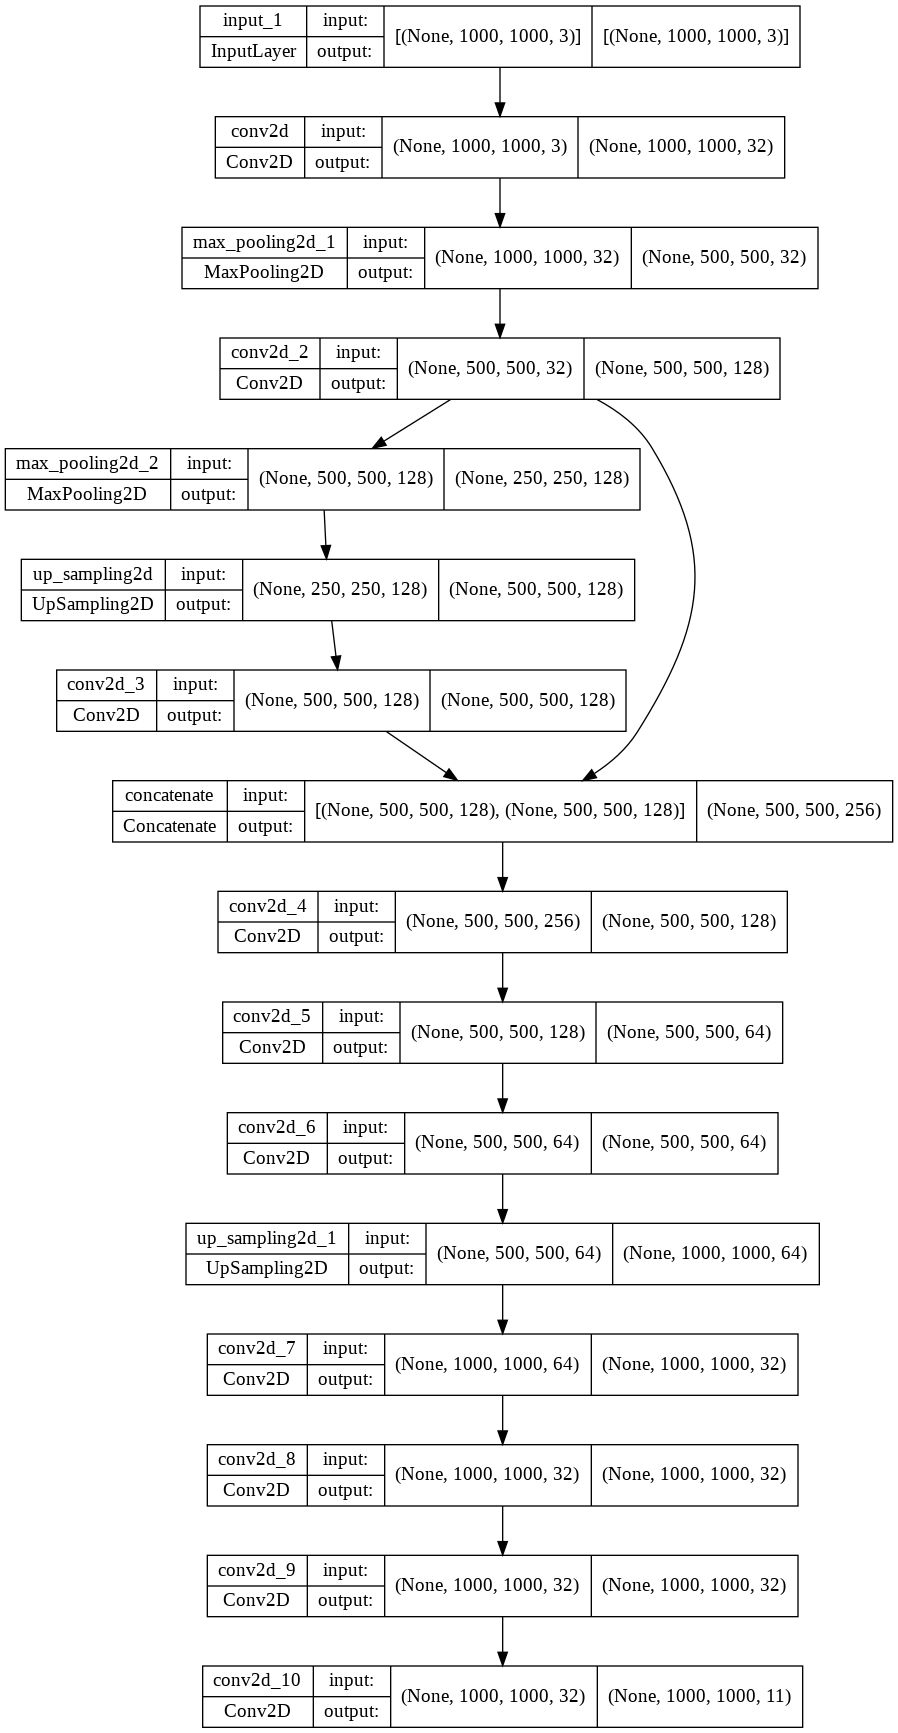

In [ ]:
# Model drawing

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# [TR] 6- Eğitimin gerçekleştirilmesi ve ağırlıkların kaydedilmesi
# [EN] 6- Performing the training and saving the weights

In [ ]:
# Train and save

histories = []
if os.path.exists(HISTORY_PATH):
  print("histories loading")
  with open(HISTORY_PATH, 'rb') as f:
    histories = pickle.load(f)

if os.path.exists(WEIGHT_PATH):
  print("weights loading")
  model.load_weights(WEIGHT_PATH)

for i in range(1000):
  print(str(i+1)+". training starting...")
  history = model.fit(x_train, y_train_one_hot, epochs=10, batch_size=2, shuffle=True, validation_data=(x_val, y_val_one_hot))
  model.save(WEIGHT_PATH)

  histories.append(history)
  with open(HISTORY_PATH, 'wb') as f:
    pickle.dump(histories, f)

In [ ]:
# Save model to disk

model.save(WEIGHT_PATH)

# [TR] 7- Kayıp ve doğruluk verilerinin değerlendirilmesi
# [EN] 7- ​​Evaluation of loss and accuracy data

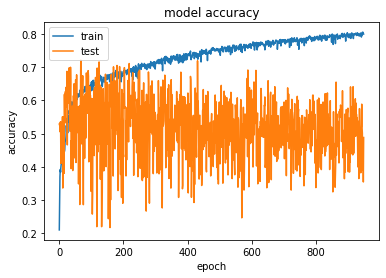

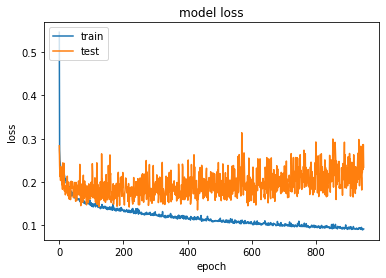

In [ ]:
# Draw train graphs

temp = get_all_histories()
draw_history_graphs(temp)

# [TR] 8- Test setinin tahmin işlemi ve önizlenmesi
# [EN] 8- Predicting and preview of test set

In [ ]:
# Predict test set

y_test_predict = model.predict(x_test)

In [ ]:
# Converto to mask from one hot vector

y_test_predict = np.argmax(y_test_predict, axis=-1)

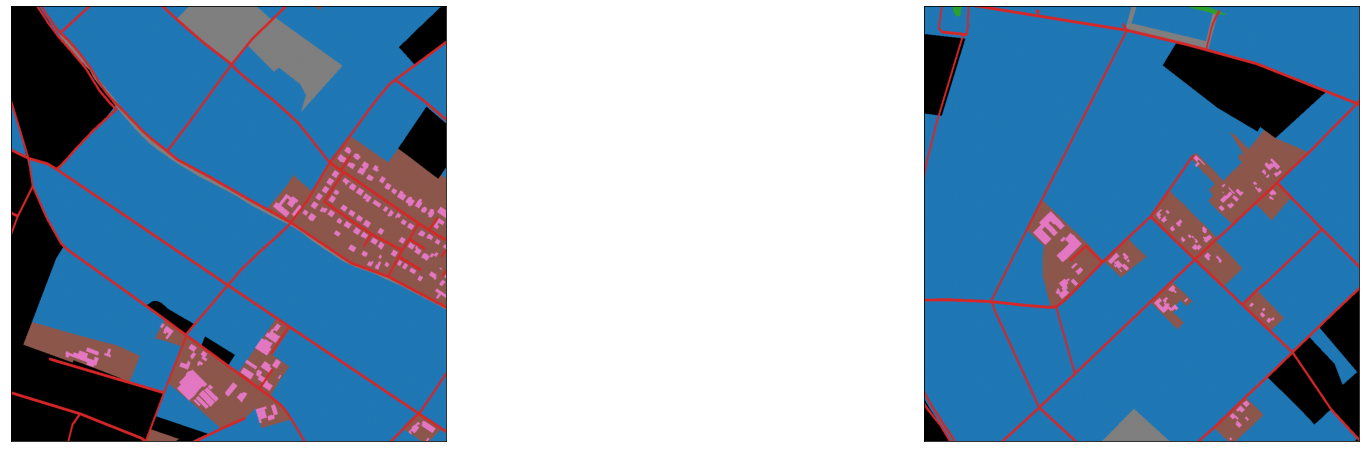

In [ ]:
# True images

preview_images(y_test, 2)

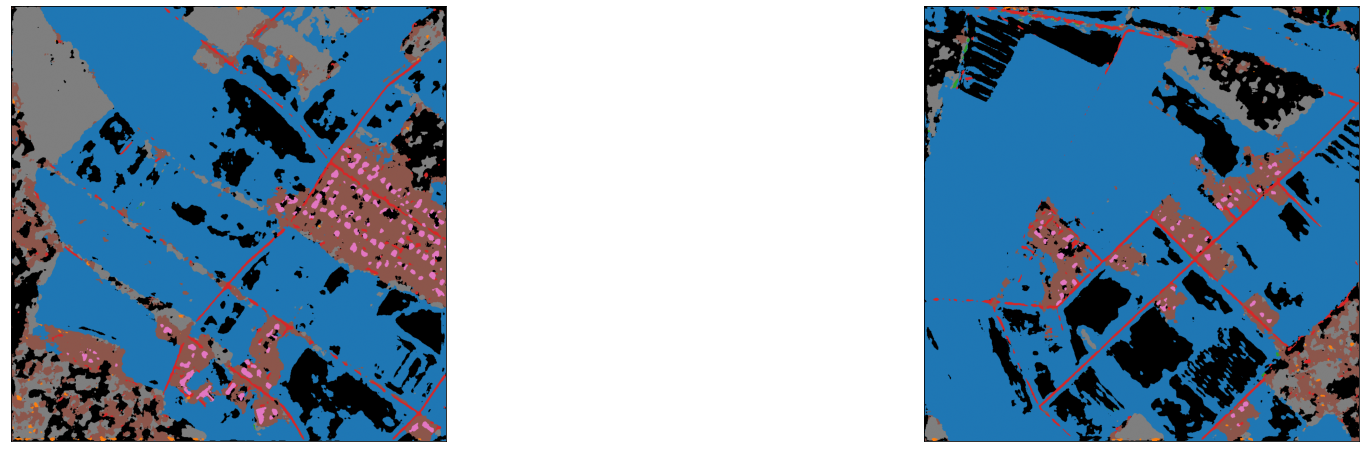

In [ ]:
# Predict images

preview_images(y_test_predict, 2)